# Feature Selection

In [7]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Automatic Feature Selection
Often we collected many features that might be related to a supervised prediction task, but we don't know which of them are actually predictive. To improve interpretability, and sometimes also generalization performance, we can use automatic feature selection to select a subset of the original features. There are several types of feature selection methods available, which we'll explain in order of increasing complexity.

For a given supervised model, the best feature selection strategy would be to try out each possible subset of the features, and evaluate generalization performance using this subset. However, there are exponentially many subsets of features, so this exhaustive search is generally infeasible. The strategies discussed below can be thought of as proxies for this infeasible computation.

### Univariate statistics
The simplest method to select features is using univariate statistics, that is by looking at each feature individually and running a statistical test to see whether it is related to the target. This kind of test is also known as analysis of variance (ANOVA).

We create a synthetic dataset that consists of the breast cancer data with an additional 50 completely random features.

In [5]:
from sklearn.datasets import load_breast_cancer, load_digits
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()

cancer['data'][0]

array([1.799e+01, 1.038e+01, 1.228e+02, 1.001e+03, 1.184e-01, 2.776e-01,
       3.001e-01, 1.471e-01, 2.419e-01, 7.871e-02, 1.095e+00, 9.053e-01,
       8.589e+00, 1.534e+02, 6.399e-03, 4.904e-02, 5.373e-02, 1.587e-02,
       3.003e-02, 6.193e-03, 2.538e+01, 1.733e+01, 1.846e+02, 2.019e+03,
       1.622e-01, 6.656e-01, 7.119e-01, 2.654e-01, 4.601e-01, 1.189e-01])

In [8]:
# get deterministic random numbers
rng = np.random.RandomState(42)
noise = rng.normal(size=(len(cancer.data), 50))
# add noise features to the data
# the first 30 features are from the dataset, the next 50 are noise
X_w_noise = np.hstack([cancer.data, noise])

X_w_noise[0].shape

X_train, X_test, y_train, y_test = train_test_split(X_w_noise, cancer.target,
                                                    random_state=0, test_size=.5)

In [11]:
X_train[0].shape

(80,)

In [13]:
y_train.mean()

0.6091549295774648

In [12]:
from sklearn.svm import SVC

model = SVC()
model.fit(X_train, y_train)
model.score(X_train, y_train), model.score(X_test, y_test)

/Users/max/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


(1.0, 0.6456140350877193)

We have to define a threshold on the p-value of the statistical test to decide how many features to keep. There are several strategies implemented in scikit-learn, a straight-forward one being ``SelectPercentile``, which selects a percentile of the original features (we select 50% below):

In [24]:
from sklearn.feature_selection import SelectPercentile

select = SelectPercentile(percentile=10)
select.fit(X_train, y_train)

X_train_selected = select.transform(X_train)

print(X_train.shape)
print(X_train_selected.shape)

select.get_support()

# pd.DataFrame(select.pvalues_).sort_values(0)

(284, 80)
(284, 8)


array([ True, False,  True, False, False, False,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False,  True,  True, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False])

In [22]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

In [23]:
model.fit(X_train_selected, y_train)

model.score(X_train_selected, y_train), model.score(select.transform(X_test), y_test)

/Users/max/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.954225352112676, 0.9473684210526315)

We can also use the test statistic directly to see how relevant each feature is. As the breast cancer dataset is a classification task, we use f_classif, the F-test for classification. Below we plot the p-values associated with each of the 80 features (30 original features + 50 noise features). Low p-values indicate informative features.

In [25]:
from sklearn.feature_selection import f_classif, f_regression, chi2

In [26]:
F, p = f_classif(X_train, y_train)

In [27]:
p

array([5.51640514e-45, 3.46425322e-11, 2.18645080e-47, 9.70050454e-40,
       9.58087702e-11, 1.00442540e-30, 9.92655032e-44, 9.27901830e-60,
       8.25490889e-09, 6.18634916e-01, 1.28757935e-22, 4.50659277e-01,
       1.98980582e-21, 7.05784521e-19, 1.72753337e-01, 5.34478580e-05,
       2.80222836e-03, 2.12916331e-09, 8.83540332e-01, 6.59871003e-01,
       5.58240697e-55, 3.79831322e-14, 4.76970683e-56, 3.01032050e-44,
       2.00672452e-15, 3.06147039e-29, 7.85629961e-40, 1.96090436e-68,
       1.26566849e-14, 8.21971053e-08, 4.75817399e-01, 6.39428907e-01,
       8.66981267e-01, 5.30249526e-02, 4.43246139e-01, 5.48773945e-02,
       8.90389380e-01, 6.53613179e-01, 1.31606460e-01, 5.04333205e-01,
       7.80060310e-01, 6.68306737e-01, 8.13067647e-01, 4.17384146e-02,
       6.96012406e-01, 5.39231778e-01, 2.13081205e-01, 2.35501173e-01,
       7.18450939e-01, 2.09324230e-01, 7.66702129e-01, 4.77523523e-02,
       7.81849018e-01, 2.93246013e-01, 9.15986708e-01, 5.51228305e-01,
      

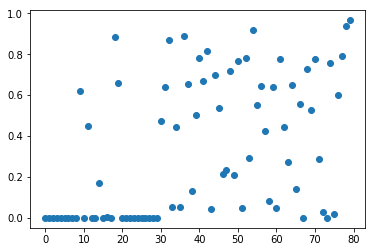

In [28]:
plt.figure()
plt.plot(p, 'o')

Clearly most of the first 30 features have very small p-values.

Going back to the SelectPercentile transformer, we can obtain the features that are selected using the ``get_support`` method:

[ True False  True False False False  True  True False False False False
 False False False False False False False False  True False  True  True
 False False False  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False]


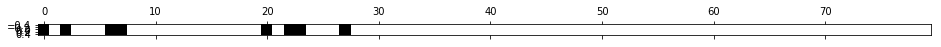

In [29]:
mask = select.get_support()
print(mask)
# visualize the mask. black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')

Nearly all of the original 30 features were recovered.
We can also analize the utility of the feature selection by training a supervised model on the data.
It's important to learn the feature selection only on the training set!

In [32]:
from sklearn.linear_model import LogisticRegression

select = SelectPercentile(percentile=50)
select.fit(X_train, y_train)

X_train_selected = select.transform(X_train)
X_test_selected = select.transform(X_test)

lr = LogisticRegression(solver='lbfgs', max_iter=5000)
lr.fit(X_train, y_train)
print(f"Score with all features: {lr.score(X_test, y_test)}")
lr.fit(X_train_selected, y_train)
print(f"Score with only selected features: {lr.score(X_test_selected, y_test)}")

Score with all features: 0.9508771929824561
Score with only selected features: 0.9333333333333333


### Model-based Feature Selection
A somewhat more sophisticated method for feature selection is using a supervised machine learning model and selecting features based on how important they were deemed by the model. This requires the model to provide some way to rank the features by importance. This can be done for all tree-based models (which implement ``get_feature_importances``) and all linear models, for which the coefficients can be used to determine how much influence a feature has on the outcome.

Any of these models can be made into a transformer that does feature selection by wrapping it with the ``SelectFromModel`` class:

In [45]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

select = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), max_features=10)

In [46]:
select.fit(X_train, y_train)
X_train_rf = select.transform(X_train)
print(X_train.shape)
print(X_train_rf.shape)

(284, 80)
(284, 10)


In [43]:
select.get_support()

array([False, False, False,  True, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False])

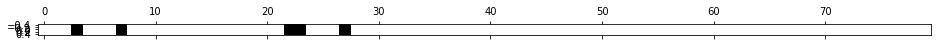

In [44]:
mask = select.get_support()

plt.matshow(mask.reshape(1, -1), cmap='gray_r')

In [47]:
X_test_rf = select.transform(X_test)
LogisticRegression(solver='lbfgs', max_iter=5000).fit(X_train_rf, y_train).score(X_test_rf, y_test)

0.9508771929824561

This method builds a single model (in this case a random forest) and uses the feature importances from this model.
We can do a somewhat more elaborate search by training multiple models on subsets of the data. One particular strategy is recursive feature elimination:

### Recursive Feature Elimination
Recursive feature elimination builds a model on the full set of features, and similar to the method above selects a subset of features that are deemed most important by the model. However, usually only a single feature is dropped from the dataset, and a new model is built with the remaining features. The process of dropping features and model building is repeated until there are only a pre-specified number of features left:

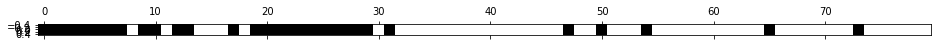

In [48]:
from sklearn.feature_selection import RFE

select = RFE(RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=30)

select.fit(X_train, y_train)

mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')

In [49]:
X_train_rfe = select.transform(X_train)
X_test_rfe = select.transform(X_test)

LogisticRegression().fit(X_train_rfe, y_train).score(X_test_rfe, y_test)

/Users/max/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9543859649122807

In [50]:
select.score(X_test, y_test)

0.9333333333333333